In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lifelines

# Loading the data

We wrapped the code that loads the data into its own Python script, called `main`. We will invoke it here.

In [2]:
import main
full_train = main.load_data(train=True)

2023-03-26 00:22:35,036	ERROR services.py:1365 -- Failed to start the dashboard: Failed to start the dashboard, return code 0
 The last 10 lines of /tmp/ray/session_2023-03-26_00-22-31_570257_2059974/logs/dashboard.log:
  File "/home/sam/micromamba/envs/datathon/lib/python3.10/site-packages/ray/dashboard/head.py", line 105, in _configure_http_server
    http_server = HttpServerDashboardHead(
  File "/home/sam/micromamba/envs/datathon/lib/python3.10/site-packages/ray/dashboard/http_server_head.py", line 68, in __init__
    raise ex
  File "/home/sam/micromamba/envs/datathon/lib/python3.10/site-packages/ray/dashboard/http_server_head.py", line 59, in __init__
    build_dir = setup_static_dir()
  File "/home/sam/micromamba/envs/datathon/lib/python3.10/site-packages/ray/dashboard/http_server_head.py", line 30, in setup_static_dir
    raise dashboard_utils.FrontendNotFoundError(
ray.dashboard.utils.FrontendNotFoundError: [Errno 2] Dashboard build directory not found. If installing from sour

The data is quite large, and we can more quickly squeeze out all of the insights from a random sample of the data. **If your machine is powerful enough**, comment this line out.

In [3]:
train = full_train.sample(frac=0.05, random_state=0)
#train = full_train

Note that not all of these columns actually exist in the forecast data (their value is unknown). Therefore, we create `useful_columns`. But we need to keep `charge_off` for scoring.

In [4]:
useful_columns = list((set(train.columns) - set(main.hidden_cols)) | {"charge_off"})
useful_columns.sort()

# Data cleaning

FICO scores are stored as buckets (categorical). Rather than find a coefficient for each bucket independently, we will replace this with a numerical value, and find one coefficient to multiply it by. We want to map each bucket to its midpoint.

In [5]:
train["bank_fico_buckets_20"].value_counts()

761+         104054
701-720       27636
681-700       27489
721-740       26171
661-680       25282
741-760       22812
641-660       20797
621-640       13390
601-620        7661
581-600        4099
<= 560         3895
561-580        2690
Missing        1531
Exception       404
Name: bank_fico_buckets_20, dtype: int64

In [6]:
def convert_fico(fico_bucket):
    fico_bucket=str(fico_bucket)
    if fico_bucket == '761+':
        return (761+850)/2
    elif fico_bucket == '<= 560':
        return (560+300)/2
    elif fico_bucket == 'Exception' or fico_bucket == 'Missing':
        return np.NaN
    else:
        lower, upper = fico_bucket.split('-')
        return (float(lower)+float(upper))/2

def add_fico_score(df):
    df['fico_score'] = df['bank_fico_buckets_20'].apply(convert_fico)
    return df

train = add_fico_score(train)

Unfortunately, there are some missing data in the fico scores.

In [7]:
pd.isna(train["fico_score"]).value_counts()

False    285976
True       1935
Name: fico_score, dtype: int64

In [8]:
train['fico_score'].fillna(train['fico_score'].mean(), inplace=True)

Now we drop columns that are more than 50% NaNs.

In [9]:
nan_features = []
threshold = 0.5
for feature in useful_columns:
    if train[feature].isna().sum() / len(train) > threshold:
        nan_features.append(feature)
train.drop(nan_features, axis=1, inplace=True)
nan_features

['charge_off_reason_code', 'variable_rate_margin', 'writeoff_date']

# Feature selection

Now we compute the correlation matrix to identify features to use in our model. Note that we take an absolute value because we don't care if the feature is positively or negatively correlated.

In [10]:
train_corr = train.corr(numeric_only=True)
abs(train_corr['charge_off']).sort_values(ascending=False).head(20)

active                      1.000000
charge_off                  1.000000
writeoff_type_null          0.997312
charge_off_aged             0.931846
writeoff_type_aged          0.904050
fee_reversals               0.747117
total_writeoff_amt          0.699818
fee_chg_off_reversal_amt    0.686676
aged_writeoff_amt           0.673954
principal_amt_chrg_off      0.590894
fc_reversals                0.561186
charge_off_bk               0.337164
writeoff_type_bko           0.327094
bankruptcy_writeoff_amt     0.253221
other_writeoff_amt          0.222558
writeoff_type_deceased      0.219405
nbr_mths_due                0.214421
writeoff_type_settlement    0.196919
fico_score                  0.100286
recovery_amt                0.089682
Name: charge_off, dtype: float64

We found out the hard way that `total_writeoff_amt` and `principal_amt_chrg_off` is too correlated with the target and will cause divergence problem in the CPH fitting process, so we exclude these two features

In [11]:
features = [
    'nbr_mths_due',
    'fico_score',
    'credit_limit_amt',
    'prev_balance',
    'financial_active',
    'purchase_active',
    'promotion_flag',
    'active_12_mths'
]

Now we select these features and standardize.

In [12]:
temp = train[features]
# Save these for later!
temp_mean = temp.mean()
temp_std = temp.std()
X = (temp - temp_mean) / temp_std
X['time_elapsed'] = train['time_elapsed']
X['charge_off'] = train['charge_off']

# Survival analysis

To use these numerical features, we find that CPH only converge with a penalizer, but when there is a penalizer, the coefficients are all close to 1, which is hard to intepret.

In [13]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=1)
cph.fit(X, duration_col='time_elapsed', event_col='charge_off')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 287911 total observations, 287165 right-censored observations>
             duration col = 'time_elapsed'
                event col = 'charge_off'
                penalizer = 1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 287911
number of events observed = 746
   partial log-likelihood = -8652.94
         time fit was run = 2023-03-26 05:23:39 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
nbr_mths_due       0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
fico_score        -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
credit_limit_amt  -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
prev_balance       0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
financial_active   0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
purchase_active   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
promotion_flag     0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
active_12_mths     0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

                   cmp to     z      p   -log2(p)
covariate                                        
nbr_mths_due         0.00  5.85 <0.005      27.61
fico_score           0.00 -2.73   0.01       7.29
credit_limit_amt     0.00 -1.50   0.13       2.90
prev_balance         0.00  1.28   0.20       2.31
financial_active     0.00  0.95   0.34       1.54
purchase_active      0.00 -0.65   0.52       0.96
promotion_flag       0.00  0.56   0.58       0.80
active_12_mths       0.00  0.49   0.62       0.68
---
Concordance = 0.96
Partial AIC = 17321.88
log-likelihood ratio test = 47.43 on 8 df
-log2(p) of ll-ratio test = 22.91

This plot shows us CI of the coefficients of the various factors on the hazard function. If the coefficient is positive, then the factor increases the probability of chargeoff. If the coefficient straddles zero, the feature is likely not relevant.

<AxesSubplot: xlabel='log(HR) (95% CI)'>

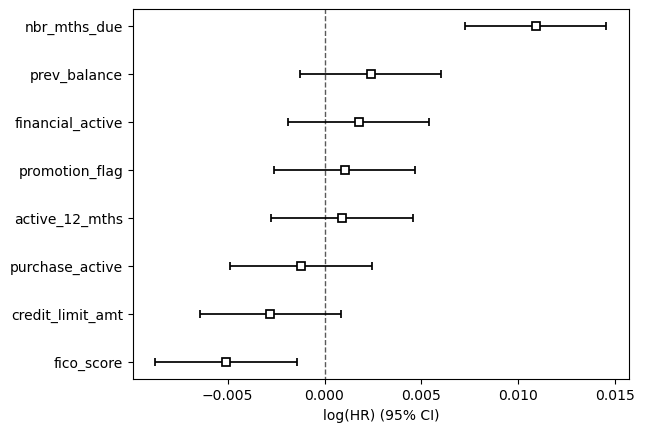

In [14]:
cph.plot()

Most of the coefficients are close to zero, which means they have a very small impact on the result. We can also see this from the partial effects graph:

<AxesSubplot: >

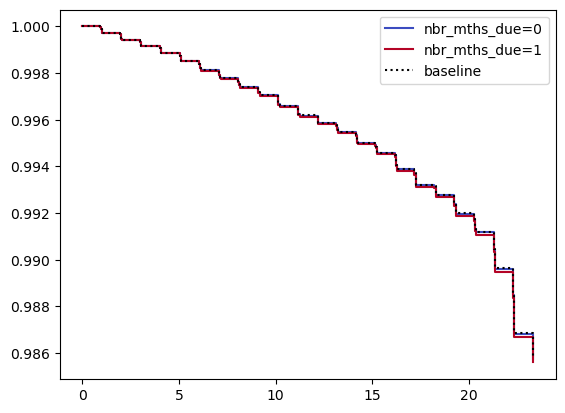

In [15]:
cph.plot_partial_effects_on_outcome(covariates='nbr_mths_due', values=[0, 1], cmap='coolwarm')

# Survival analysis with quantized features

Outliers and non-linear effects can greatly influence the survival analysis, so we exclude those by thresholding the data. Instead of entering the data directly, we just enter if it is greater than the threshold.

In [16]:
def add_quantized_features(df):
    #Also adding a column with low/high (0/1) credit score (using 661 and up as high based off a quick google search)
    df['fico_low_high'] = df['fico_score'].map(lambda x: 1.0 if x <= 660 else 0.0)

    #Create column with high/low credit limit amounts (>5000) high
    df['credit_limit_high_low'] = df['credit_limit_amt'].map(lambda x: 1.0 if x < 5000 else 0.0)

    #Creating a column with difference between current balance and previous balance
    df['balance_diff'] = df['stmt_balance'] - df['prev_balance']

    #Creating a column with low/high increase in balance from previous statement (high >5000)
    df['new_balance_diff_high_low'] = df['balance_diff'].map(lambda x: 1.0 if x < 5000 else 0.0)

    #Creating column with low/high number of monthly payments due (high >=5)
    df['mths_due_high_low'] = df['nbr_mths_due'].map(lambda x: 1.0 if x >= 5 else 0.0)
    
    return df

train = add_quantized_features(train)    

train

,financial_active,net_payment_behaviour_tripd,promotion_flag,variable_rate_index,account_status_code,active_12_mths,bank_fico_buckets_20,mob,open_closed_flag,ever_delinquent_flg,...,snapshot,mth_code,industry,time_elapsed,fico_score,fico_low_high,credit_limit_high_low,balance_diff,new_balance_diff_high_low,mths_due_high_low
3613772,True,I,False,False,I 7-12,True,621-640,57,1.0,True,...,2018-10-01,2018-10-01,B,0.000000,630.5,1.0,1.0,1310.99,1.0,0.0
3887009,False,I,True,False,A,True,681-700,145,1.0,False,...,2018-11-01,2018-11-01,B,0.000000,690.5,0.0,1.0,0.00,1.0,0.0
2721972,False,P,True,False,I 13-24,True,761+,15,1.0,False,...,2018-07-01,2019-12-01,B,17.266667,805.5,0.0,0.0,-556.15,1.0,0.0
77795,True,I,False,False,A,True,721-740,17,1.0,False,...,2018-01-01,2018-09-01,B,8.100000,730.5,0.0,0.0,-2456.99,1.0,0.0
5133318,False,P,False,False,A,True,701-720,10,1.0,False,...,2019-05-01,2019-10-01,C,5.100000,710.5,0.0,0.0,0.00,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2590380,True,T,False,True,A,True,761+,29,1.0,False,...,2018-07-01,2019-09-01,B,14.233333,805.5,0.0,1.0,974.34,1.0,0.0
4681108,False,T,True,False,A,True,761+,166,1.0,False,...,2019-02-01,2019-12-01,B,10.100000,805.5,0.0,1.0,0.00,1.0,0.0
845518,True,P,True,True,I 13-24,True,761+,138,1.0,False,...,2018-02-01,2019-07-01,A,17.166667,805.5,0.0,1.0,0.00,1.0,0.0
5132771,False,I,False,False,I 13-24,True,761+,156,1.0,False,...,2019-05-01,2019-09-01,A,4.100000,805.5,0.0,1.0,13.96,1.0,0.0


In [17]:
quantized_features = ['financial_active', 'fico_low_high', 'ever_delinquent_flg', 'credit_limit_high_low', 'new_balance_diff_high_low']
cph = CoxPHFitter(penalizer=0)
cph.fit(
    train[['time_elapsed', 'charge_off', *quantized_features]],
    duration_col='time_elapsed',
    event_col='charge_off',
)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 287911 total observations, 287165 right-censored observations>
             duration col = 'time_elapsed'
                event col = 'charge_off'
      baseline estimation = breslow
   number of observations = 287911
number of events observed = 746
   partial log-likelihood = -7611.09
         time fit was run = 2023-03-26 05:23:43 UTC

---
                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                         
financial_active            2.65      14.19       0.19             2.29             3.02                 9.84                20.44
fico_low_high               2.60      13.52       0.08             2.44             2.77                11.46                15.96
ever_delinquent_flg         0.18       1.19       0.11            -0.04             0.39                 0.96                 1.47
credit_limit_high_low       2.65      14.18       0.18             2.29             3.01                 9.90                20.32
new_balance_diff_high_low   1.44       4.21       0.50             0.45             2.42                 1.58                11.24

                            cmp to     z      p   -log2(p)
covariate                                                 
financial_active              0.00 14.23 <0.005     150.25
fico_low_high                 0.00 30.77 <0.005     688.37
ever_delinquent_flg           0.00  1.62   0.10       3.26
credit_limit_high_low         0.00 14.46 <0.005     154.94
new_balance_diff_high_low     0.00  2.87 <0.005       7.91
---
Concordance = 0.89
Partial AIC = 15232.18
log-likelihood ratio test = 2131.13 on 5 df
-log2(p) of ll-ratio test = inf

<AxesSubplot: xlabel='log(HR) (95% CI)'>

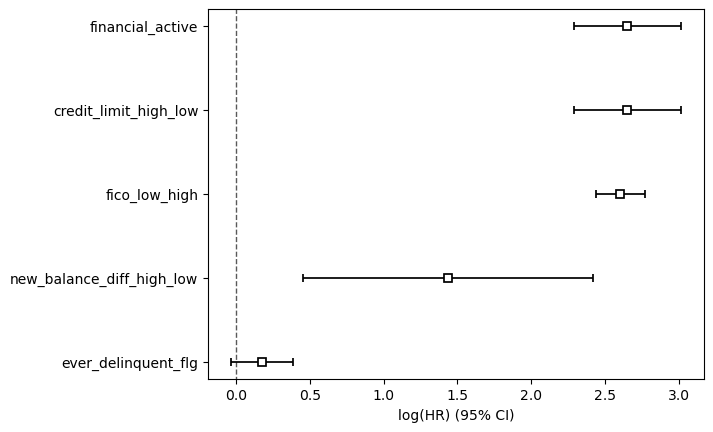

In [18]:
cph.plot()

This model does much better. Let's look at the partial_effects plot.

<AxesSubplot: >

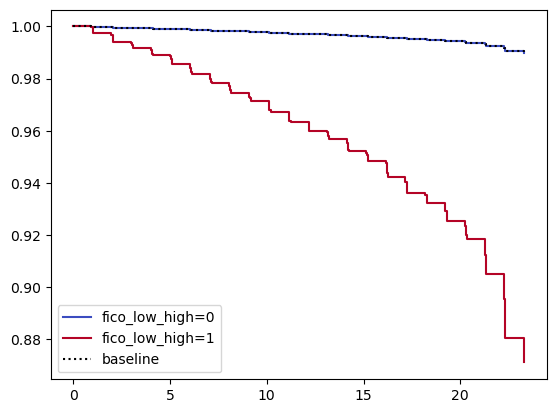

In [19]:
cph.plot_partial_effects_on_outcome(covariates='fico_low_high', values=[0, 1], cmap='coolwarm')

# Survival analysis with quantized and categorical features

We know that several categorical variables impact the chargeoff outcome. To encode these variables, we use a one-hot encoding.

In [20]:
cat_vars = ['net_payment_behaviour_tripd', 'account_status_code', 'industry']
def one_hot_encode(df):
    return pd.get_dummies(df, columns=cat_vars, drop_first=True)
train = one_hot_encode(train)

In [21]:
net_payment_behaviour_tripd_features = []
account_status_code_features = []
industry_features = []

for column in train.columns:
    if column.startswith('net_payment_behaviour_tripd'):
        net_payment_behaviour_tripd_features.append(column)
    elif column.startswith('account_status_code'):
        account_status_code_features.append(column)
    elif column.startswith('industry'):
        industry_features.append(column)
net_payment_behaviour_tripd_features, account_status_code_features, industry_features

(['net_payment_behaviour_tripd_D',
  'net_payment_behaviour_tripd_I',
  'net_payment_behaviour_tripd_P',
  'net_payment_behaviour_tripd_R',
  'net_payment_behaviour_tripd_T'],
 ['account_status_code_I 0-6',
  'account_status_code_I 13-24',
  'account_status_code_I 25+',
  'account_status_code_I 7-12',
  'account_status_code_MonthEnd',
  'account_status_code_Recovery',
  'account_status_code_W',
  'account_status_code_Clchange'],
 ['industry_B', 'industry_C'])

In [22]:
cph = CoxPHFitter(penalizer=0)
cph.fit(
    train[['time_elapsed', 'charge_off', *quantized_features, *industry_features]],
    duration_col='time_elapsed',
    event_col='charge_off',
)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 287911 total observations, 287165 right-censored observations>
             duration col = 'time_elapsed'
                event col = 'charge_off'
      baseline estimation = breslow
   number of observations = 287911
number of events observed = 746
   partial log-likelihood = -7572.86
         time fit was run = 2023-03-26 05:23:45 UTC

---
                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                         
financial_active            2.65      14.17       0.19             2.29             3.02                 9.84                20.42
fico_low_high               2.60      13.47       0.08             2.43             2.77                11.41                15.90
ever_delinquent_flg         0.18       1.20       0.11            -0.03             0.40                 0.97                 1.49
credit_limit_high_low       2.65      14.13       0.18             2.29             3.01                 9.86                20.25
new_balance_diff_high_low   1.44       4.24       0.50             0.46             2.43                 1.59                11.32
industry_B                 -0.70       0.50       0.08            -0.86            -0.54                 0.42                 0.58
industry_C                 -0.63       0.53       0.11            -0.85            -0.41                 0.43                 0.66

                            cmp to     z      p   -log2(p)
covariate                                                 
financial_active              0.00 14.23 <0.005     150.16
fico_low_high                 0.00 30.73 <0.005     686.35
ever_delinquent_flg           0.00  1.70   0.09       3.50
credit_limit_high_low         0.00 14.44 <0.005     154.52
new_balance_diff_high_low     0.00  2.88 <0.005       7.98
industry_B                    0.00 -8.75 <0.005      58.72
industry_C                    0.00 -5.69 <0.005      26.22
---
Concordance = 0.90
Partial AIC = 15159.71
log-likelihood ratio test = 2207.60 on 7 df
-log2(p) of ll-ratio test = inf

<AxesSubplot: xlabel='log(HR) (95% CI)'>

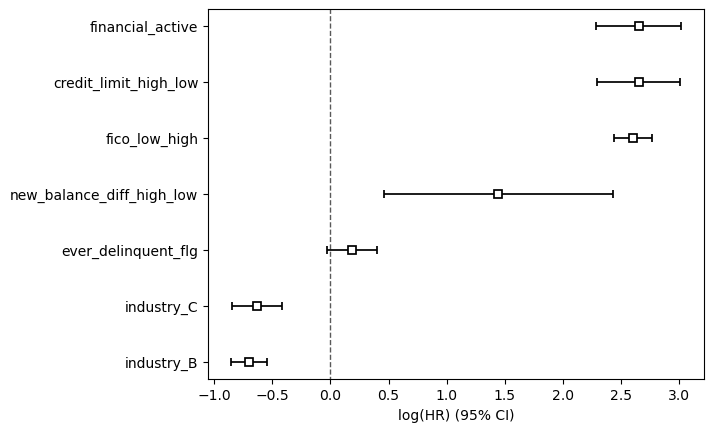

In [23]:
cph.plot()

Now we are incorporating a categorical feature!

<AxesSubplot: >

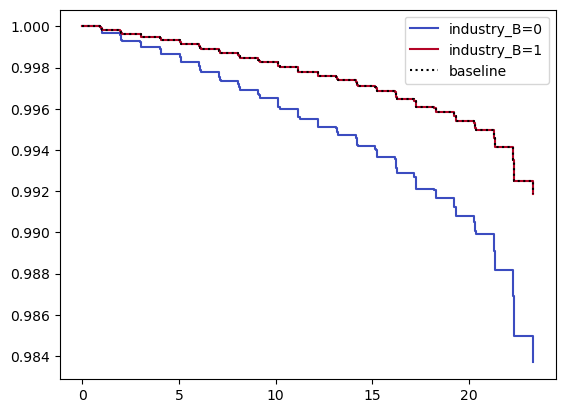

In [24]:
cph.plot_partial_effects_on_outcome(covariates='industry_B', values=[0, 1], cmap='coolwarm')

# Macro data

In [25]:
macro_data = pd.read_csv('data/macro_data.csv')
macro_data.head(10)

,Mnemonic,M_FHOFHOPIPOQ.IUSA,M_FYLE.IUSA,M_FRT.IUSA,M_FYPSAVQ.IUSA,M_FC.IUSA,FYPCPICA_FEDB.IUSA,M_FGDP.IUSA,M_FYHHAVGQ.IUSA,M_FYFMMEDQ.IUSA,...,M_FBCFCOFCCQ.IUSA,M_FETP.IUSA,M_FLTV.IUSA,M_FC$.IUSA,M_FEIAMGTTQ.IUSA,M_FXCPMGASUQ.IUSA,M_FRBBBQ.IUSA,M_FHOWNRQ.IUSA,M_FIFR_FEDS.IUSA,M_FIFR$_FEDS.IUSA
0,Description,Baseline Scenario (October 2022): FHFA Purchas...,Baseline Scenario (October 2022): NIPA: Income...,Baseline Scenario (October 2022): Retail Sales...,Baseline Scenario (October 2022): Income: Pers...,Baseline Scenario (October 2022): NIPA: Person...,Baseline Scenario (October 2022): Income: Per ...,Baseline Scenario (October 2022): NIPA: Gross ...,Baseline Scenario (October 2022): Average Hous...,Baseline Scenario (October 2022): Median Famil...,...,Baseline Scenario (June 2020): Charge Off Rate...,Baseline Scenario (June 2020): Employment: Tot...,Baseline Scenario (June 2020): Terms Conventio...,Baseline Scenario (June 2020): NIPA: Personal ...,Baseline Scenario (June 2020): U.S. All Grades...,Baseline Scenario (June 2020): Motor gasoline ...,Baseline Scenario (June 2020): Merrill Lynch 1...,Baseline Scenario (June 2020): Homeownership R...,FRB CCAR 2020 - Severely Adverse: NIPA: Fixed ...,FRB CCAR 2020 - Severely Adverse: NIPA: Fixed ...
1,Name,"FHFA Purchase-Only Home Price Index, (Index 19...","NIPA: Income - Compensation of Employees, (Bil...","Retail Sales - Retail Sales Total, (Bil. USD, ...","Income: Personal - Saving Rate, (%, SA)",NIPA: Personal Consumption Expenditures - Tota...,"Income: Per Capita Income, (USD)","NIPA: Gross Domestic Product, (Bil. USD, SAAR)","Average Household Income: All Races, (USD, SA)","Median Family Income: All Races, (USD, SA)",...,Charge Off Rates: All Commercial Banks - Credi...,"Employment: Total Private, (Mil. #, SA)",Terms Conventional Mortgages: All Loans - Comp...,NIPA: Personal Consumption Expenditures - Tota...,U.S. All Grades All Formulations Retail Gasoli...,"Motor gasoline prices: Unleaded, (Cents per ga...","Merrill Lynch 10-Year Bbb Corporate Bond Rate,...","Homeownership Rate, (%, SA)","NIPA: Fixed Investment - Residential - Total, ...","NIPA: Fixed Investment - Residential - Total, ..."
2,Source,U.S. Federal Housing Finance Agency (FHFA); Fr...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Census Bureau (BOC); Moody's Analytics Fo...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Census Bureau (BOC); U.S. Bureau of Econo...,U.S. Census Bureau (BOC); Moody's Analytics Fo...,...,U.S. Board of Governors of the Federal Reserve...,U.S. Bureau of Labor Statistics (BLS); Moody's...,U.S. Federal Housing Finance Board (FHFB); Moo...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Energy Information Administration (EIA); ...,Oil Price Information Service (OPIS); Moody's ...,U.S. Board of Governors of the Federal Reserve...,U.S. Census Bureau (BOC); Moody's Analytics Fo...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Bureau of Economic Analysis (BEA); Moody'...
3,Native Frequency,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY,ANNUAL,MONTHLY,MONTHLY,MONTHLY,...,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY
4,Geography,United States,United States,United States,United States,United States,United States,United States,United States,United States,...,United States,United States,United States,United States,United States,United States,United States,United States,United States,United States
5,Last Updated,10/11/2022,10/11/2022,10/11/2022,10/11/2022,10/11/2022,10/10/2022,10/11/2022,10/11/2022,10/11/2022,...,6/9/2020,6/9/2020,6/9/2020,6/9/2020,6/9/2020,6/9/2020,6/9/2020,6/9/2020,2/8/2020,2/8/2020
6,Historical End Date,7/31/2022,8/31/2022,8/31/2022,8/31/2022,8/31/2022,12/31/2020,6/30/2022,6/30/2020,3/31/2022,...,12/31/2019,5/31/2020,4/30/2019,4/30/2020,5/31/2020,5/31/2020,9/30/2018,3/31

In [26]:
# data starts from row 7
macro_data_clean = macro_data.iloc[7:,:].copy()
# The first column, labelled "mnemonic", contains the date
# The macro data is collated for the last day of the month.
# We will reindex this as the first day of the next month, so we can match it against mth_code
macro_data_clean['mth_code'] = pd.DatetimeIndex(pd.to_datetime(macro_data_clean['Mnemonic'])) + pd.DateOffset(1)
# These get read as strings; need to convert to floats
real_cols = [col for col in macro_data_clean.columns if col.startswith("M_")]
for col in real_cols:
    macro_data_clean[col] = macro_data_clean[col].apply(lambda x: pd.to_numeric(x, errors="coerce"))

We want to correlate the macroeconomic trends with the monthly chargeoff rate, which we compute below:

In [27]:
train_mth_code = (
      train[['mth_code', 'charge_off']].groupby('mth_code').sum()
    / train[['mth_code', 'charge_off']].groupby('mth_code').count()
)
train_mth_code

,charge_off
mth_code,
2018-01-01,0.000000
2018-02-01,0.000490
2018-03-01,0.004062
2018-04-01,0.002010
2018-05-01,0.002023
2018-06-01,0.002859
2018-07-01,0.003207
2018-08-01,0.003120
2018-09-01,0.002990


In [28]:
train_macro_combined = train_mth_code.merge(macro_data_clean, on='mth_code').drop(['Mnemonic'], axis=1)
train_macro_combined

,mth_code,charge_off,M_FHOFHOPIPOQ.IUSA,M_FYLE.IUSA,M_FRT.IUSA,M_FYPSAVQ.IUSA,M_FC.IUSA,FYPCPICA_FEDB.IUSA,M_FGDP.IUSA,M_FYHHAVGQ.IUSA,...,M_FBCFCOFCCQ.IUSA,M_FETP.IUSA,M_FLTV.IUSA,M_FC$.IUSA,M_FEIAMGTTQ.IUSA,M_FXCPMGASUQ.IUSA,M_FRBBBQ.IUSA,M_FHOWNRQ.IUSA,M_FIFR_FEDS.IUSA,M_FIFR$_FEDS.IUSA
0,2018-01-01,0.000000,247.111273,10714.677,5209.548,6.3,13609.029,52856.89199,20034.78511,137521.2505,...,3.672078,125.170,79.000000,12785.503,2.59375,248.2625,3.938416,64.075495,782.325839,621.133072
1,2018-02-01,0.000490,248.873161,10761.294,5181.420,7.1,13628.374,53049.86599,20073.62463,138178.1894,...,3.664279,125.317,79.500000,12775.504,2.67120,253.4600,4.058025,64.182997,782.999266,616.305314
2,2018-03-01,0.004062,250.867813,10780.022,5215.572,7.2,13668.318,53233.38442,20141.45839,138578.5727,...,3.650039,125.672,79.300000,12765.158,2.70475,256.9375,4.206673,64.299439,783.218171,611.378013
3,2018-04-01,0.002010,251.669258,10808.394,5198.868,7.2,13735.355,53417.1033,20251.37579,139015.1391,...,3.635683,125.850,79.200000,12808.044,2.70900,255.9775,4.374299,64.417509,784.849562,608.511673
4,2018-05-01,0.002023,252.396284,10850.006,5220.732,7.2,13792.129,53607.57795,20361.75240,139415.5111,...,3.627844,125.977,79.200000,12863.202,2.87320,272.1040,4.530713,64.508728,787.505316,607.257917
5,2018-06-01,0.002859,253.727295,10884.605,5277.108,7.2,13860.171,53798.93234,20482.75073,139951.8411,...,3.634638,126.238,78.900000,12918.212,2.98675,290.1200,4.625637,64.528112,789.935821,606.495716
6,2018-07-01,0.003207,254.826464,10938.375,5250.324,7.4,13900.213,53991.49272,20566.09014,140544.0184,...,3.657519,126.429,78.700000,12946.163,2.96950,292.2250,4.637647,64.462223,791.133864,605.149367
7,2018-08-01,0.003120,255.897096,11000.556,5285.064,7.5,13952.254,54185.6046,20646.54348,141261.2749,...,3.680373,126.562,79.000000,12992.581,2.92780,288.4640,4.612022,64.375857,790.916523,603.062019
8,2018-09-01,0.002990,257.158370,11056.842,5278.512,7.6,14001.103,54384.72451,20705.33069,141810.1233,...,3.681015,126.778,78.800000,13035.279,2.91425,287.6625,4.617717,64.360913,789.302998,600.235604
9,2018-10-01,0.002948,257.554349,11071.396,5272.152,7.7,14013.025,54582.57541,20709.96619,141969.5417,...,3.648614,126.859,78.000000,13031.547,2.91475,287.2450,4.696259,64.465337,786.732479,597.056377


# Feature selection for macroeconomic trends

In [29]:
# Compute mutual information of columns of financial index with charge_off frequency
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(
    train_macro_combined.drop(columns=["mth_code", "charge_off"]),
    train_macro_combined["charge_off"],
)
mi_scores[:3]  # show a few features with their MI scores

M_FYPSAVQ.IUSA    0.581686
M_FRT.IUSA        0.559064
M_FCPIU.IUSA      0.538222
Name: MI Scores, dtype: float64

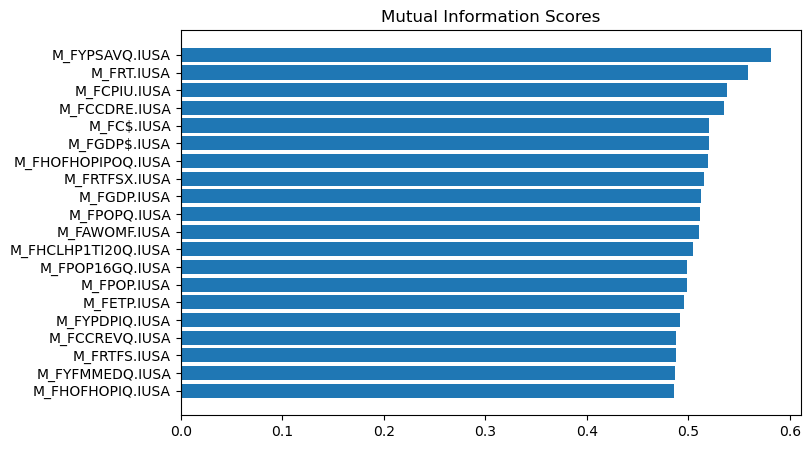

In [30]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores[:20])

Thus we add the M_FRBAAC.IUSA and M_FRBBBQ.IUSA columns in the training data

In [31]:
macro_features = ['M_FRBAAC.IUSA', 'M_FRBBBQ.IUSA']
train = train.merge(train_macro_combined[['mth_code', *macro_features]], on='mth_code')

In [32]:
cph = CoxPHFitter()
cph.fit(
    train[['time_elapsed', 'charge_off', *quantized_features, *industry_features, *macro_features]],
    duration_col='time_elapsed',
    event_col='charge_off',
)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 287911 total observations, 287165 right-censored observations>
             duration col = 'time_elapsed'
                event col = 'charge_off'
      baseline estimation = breslow
   number of observations = 287911
number of events observed = 746
   partial log-likelihood = -7482.03
         time fit was run = 2023-03-26 05:23:50 UTC

---
                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                         
financial_active            2.62      13.77       0.19             2.26             2.99                 9.56                19.84
fico_low_high               2.60      13.43       0.08             2.43             2.76                11.38                15.86
ever_delinquent_flg         0.19       1.21       0.11            -0.02             0.40                 0.98                 1.49
credit_limit_high_low       2.65      14.13       0.18             2.29             3.01                 9.86                20.24
new_balance_diff_high_low   1.42       4.13       0.50             0.44             2.40                 1.55                11.03
industry_B                 -0.70       0.50       0.08            -0.86            -0.54                 0.42                 0.58
industry_C                 -0.64       0.52       0.11            -0.86            -0.43                 0.42                 0.65
M_FRBAAC.IUSA              -0.07       0.94       0.26            -0.58             0.45                 0.56                 1.57
M_FRBBBQ.IUSA               1.20       3.33       0.26             0.69             1.71                 2.00                 5.56

                            cmp to     z      p   -log2(p)
covariate                                                 
financial_active              0.00 14.07 <0.005     146.96
fico_low_high                 0.00 30.70 <0.005     684.93
ever_delinquent_flg           0.00  1.74   0.08       3.62
credit_limit_high_low         0.00 14.43 <0.005     154.47
new_balance_diff_high_low     0.00  2.83 <0.005       7.74
industry_B                    0.00 -8.75 <0.005      58.69
industry_C                    0.00 -5.82 <0.005      27.33
M_FRBAAC.IUSA                 0.00 -0.25   0.80       0.32
M_FRBBBQ.IUSA                 0.00  4.62 <0.005      18.02
---
Concordance = 0.92
Partial AIC = 14982.07
log-likelihood ratio test = 2389.25 on 9 df
-log2(p) of ll-ratio test = inf

<AxesSubplot: xlabel='log(HR) (95% CI)'>

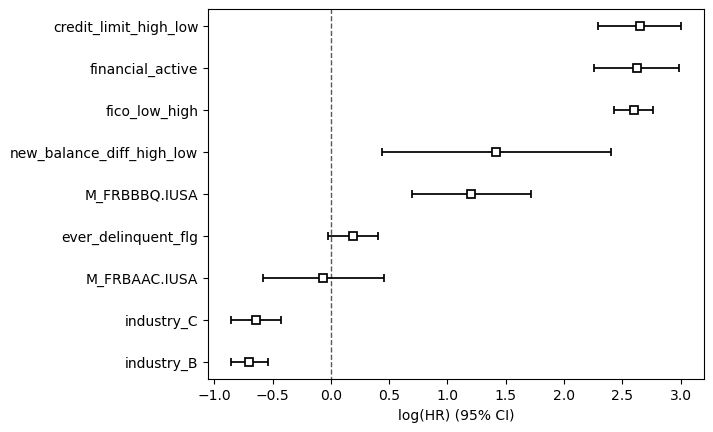

In [33]:
cph.plot()

Again, we will plot some partial effects curves to validate the significance.

<AxesSubplot: >

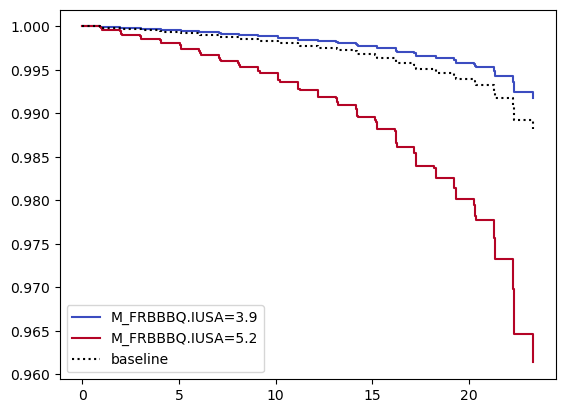

In [35]:
cph.plot_partial_effects_on_outcome(covariates='M_FRBBBQ.IUSA',values=[3.9, 5.2], cmap='coolwarm')

# The full prediction

We are asked to make predicitons for the `forecast_data.csv`.

In [36]:
forecast_data = main.load_data(train=False)
forecast_data

,financial_active,net_payment_behaviour_tripd,promotion_flag,variable_rate_index,account_status_code,active_12_mths,bank_fico_buckets_20,charge_off_reason_code,mob,open_closed_flag,...,due_balance_3,due_balance_4,due_balance_5,due_balance_6,due_balance_7,due_balance_8,snapshot,mth_code,industry,time_elapsed
0,True,T,False,False,I 0-6,True,761+,NaN,42,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01,2020-01-01,B,0.0
1,False,P,False,False,A,True,761+,NaN,48,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01,2020-01-01,B,0.0
2,False,C,False,False,I 0-6,False,761+,NaN,244,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01,2020-01-01,A,0.0
3,True,R,False,False,I 0-6,True,621-640,NaN,76,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01,2020-01-01,A,0.0
4,True,P,False,False,I 0-6,True,761+,NaN,143,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01,2020-01-01,C,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19861,True,I,True,False,I 13-24,True,621-640,NaN,26,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01,2020-01-01,A,0.0
19862,False,R,True,False,A,True,641-660,NaN,299,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01,2020-01-01,C,0.0
19863,True,I,False,False,I 0-6,True,741-760,NaN,4,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01,2020-01-01,C,0.0
19864,True,P,True,True,A,True,701-720,NaN,24,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01,2020-01-01,B,0.0


Now we must do the exact same data transformations to `forecast_data`.

In [37]:
forecast_data = add_fico_score(forecast_data)
forecast_data = add_quantized_features(forecast_data)    
forecast_data = one_hot_encode(forecast_data)

Hopefully, it all starts from the same date.

In [55]:
start_dates = list(forecast_data["snapshot"].unique())
assert len(start_dates) == 1
start_date = start_dates[0]
start_date

numpy.datetime64('2020-01-01T00:00:00.000000000')

The macroeconomic trends a bit more complicated. We want to join with the macroenomic trends for the date **of prediction**.

In [61]:
dates_of_interest = [np.datetime64(f"2020-{i:02}-01") for i in range(2, 13)] + [np.datetime64("2021-01-01")]

Suppose we select a certain datetime

In [62]:
date = dates_of_interest[7]
macro_data_clean[macro_data_clean["mth_code"] == date]

,Mnemonic,M_FHOFHOPIPOQ.IUSA,M_FYLE.IUSA,M_FRT.IUSA,M_FYPSAVQ.IUSA,M_FC.IUSA,FYPCPICA_FEDB.IUSA,M_FGDP.IUSA,M_FYHHAVGQ.IUSA,M_FYFMMEDQ.IUSA,...,M_FLTV.IUSA,M_FC$.IUSA,M_FEIAMGTTQ.IUSA,M_FXCPMGASUQ.IUSA,M_FRBBBQ.IUSA,M_FHOWNRQ.IUSA,M_FIFR_FEDS.IUSA,M_FIFR$_FEDS.IUSA,date,mth_code
254,8/31/2020,291.514853,11573.878,5788.692,15.5,14352.773,60704.02875,21364.07023,156028.7664,83874.19365,...,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-08-31,2020-09-01


Now we want to copy this one row of macro data for every row of forecast data. This can be thought of as a cross-product, $N \times 1 = N$

In [63]:
macro_info = macro_data_clean[macro_data_clean["mth_code"] == date]
new_forecast_data = pd.merge(forecast_data, macro_info, how="cross")
new_forecast_data

,financial_active,promotion_flag,variable_rate_index,active_12_mths,bank_fico_buckets_20,charge_off_reason_code,mob,open_closed_flag,ever_delinquent_flg,nbr_mths_due,...,M_FLTV.IUSA,M_FC$.IUSA,M_FEIAMGTTQ.IUSA,M_FXCPMGASUQ.IUSA,M_FRBBBQ.IUSA,M_FHOWNRQ.IUSA,M_FIFR_FEDS.IUSA,M_FIFR$_FEDS.IUSA,date,mth_code_y
0,True,False,False,True,761+,NaN,42,1.0,False,0,...,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-08-31,2020-09-01
1,False,False,False,True,761+,NaN,48,1.0,False,0,...,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-08-31,2020-09-01
2,False,False,False,False,761+,NaN,244,1.0,False,0,...,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-08-31,2020-09-01
3,True,False,False,True,621-640,NaN,76,1.0,False,0,...,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-08-31,2020-09-01
4,True,False,False,True,761+,NaN,143,1.0,False,0,...,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-08-31,2020-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19861,True,True,False,True,621-640,NaN,26,1.0,False,0,...,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-08-31,2020-09-01
19862,False,True,False,True,641-660,NaN,299,1.0,False,0,...,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-08-31,2020-09-01
19863,True,False,False,True,741-760,NaN,4,1.0,True,0,...,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-08-31,2020-09-01
19864,True,True,True,True,701-720,NaN,24,1.0,False,0,...,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-08-31,2020-09-01


Now we would use CPH to predict how long these accounts will survive.

In [69]:
predictions = cph.predict_survival_function(
    X=new_forecast_data,
    times=[(date - start_date) / pd.Timedelta(days=30)],
).T
predictions

,8.133333
0,0.999665
1,0.999976
2,0.999997
3,0.990960
4,0.999975
...,...
19861,0.990960
19862,0.999976
19863,0.999572
19864,0.999665


If we have 100 individuals each with 99% chance of survival, we simply add them up to find the expected number of survivors.
$$\mathbb E(|N|) = \sum\limits_{x \in N} \mathbb E(x) = \sum\limits_{x \in N} \mathbb P(x)$$

In [71]:
predictions.sum()

8.133333    19856.43301
dtype: float64

In [80]:
predictions_by_date = []
for date in dates_of_interest:
    macro_info = macro_data_clean[macro_data_clean["mth_code"] == date]
    assert len(macro_info) == 1
    new_forecast_data = pd.merge(forecast_data, macro_info, how="cross")
    prediction = cph.predict_survival_function(
        X=new_forecast_data,
        times=[(date - start_date) / pd.Timedelta(days=30)],
    ).sum(axis=1).iloc[0]
    predictions_by_date.append(prediction)
    print(date, prediction)

2020-02-01 19863.61025998921
2020-03-01 19861.216427666994
2020-04-01 19854.938996084766
2020-05-01 19845.91720293698
2020-06-01 19835.921477444655
2020-07-01 19843.545674998928
2020-08-01 19852.894961738424
2020-09-01 19856.433010177436
2020-10-01 19854.360142916907
2020-11-01 19844.57897296284
2020-12-01 19831.149921106513
2021-01-01 19825.561844076434


In [91]:
output = pd.DataFrame.from_records(zip(dates_of_interest, predictions_by_date), columns={"Month", "accounts_charged_off"})
output["Month"] = output["Month"].apply(lambda x: x.strftime("%Y%M"))
output["accounts_charged_off"] = output["accounts_charged_off"].astype(int)
output

,Month,accounts_charged_off
0,202000,19863
1,202000,19861
2,202000,19854
3,202000,19845
4,202000,19835
5,202000,19843
6,202000,19852
7,202000,19856
8,202000,19854
9,202000,19844


In [94]:
output.to_csv("data/result_TRUE_POSITIVES.csv")